In [1]:
import sys
sys.path.append('../APDFT')
sys.path.append('../Data')

In [2]:
from pyscf import gto, scf, dft, cc
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from FcMole import *
import os
import ast
from IPython.display import display

%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

## Load Dataset ##

In [3]:
data = np.load('../Data/Benzene_BNdoping_CCSD_ccpvdz.npz', allow_pickle=True)
charges, coords, elements, energies = data['charges'], data['coords'], data['elements'], data['energies']

In [4]:
columns = ['Charges', 'Elements', 'Energy']
benzene_data = pd.DataFrame(columns=columns)

# print(benzene_data)
benzene_data['Charges'] = charges.tolist()
benzene_data['Elements'] = elements.tolist()
benzene_data['Energy'] = energies.tolist()
display(benzene_data)

,Charges,Elements,Energy
0,"[7, 5, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, B, C, C, C, C, H, H, H, H, H, H]",-231.630120
1,"[7, 6, 5, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, B, C, C, C, H, H, H, H, H, H]",-231.560496
2,"[7, 6, 6, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, C, B, C, C, H, H, H, H, H, H]",-231.565932
3,"[7, 7, 5, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, B, C, C, H, H, H, H, H, H]",-234.786082
4,"[7, 7, 5, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, C, B, C, H, H, H, H, H, H]",-234.827144
5,"[7, 7, 5, 6, 6, 5, 1, 1, 1, 1, 1, 1]","[N, N, B, C, C, B, H, H, H, H, H, H]",-234.914257
6,"[7, 7, 6, 5, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, C, B, B, C, H, H, H, H, H, H]",-234.702319
7,"[7, 5, 7, 6, 6, 5, 1, 1, 1, 1, 1, 1]","[N, B, N, C, C, B, H, H, H, H, H, H]",-235.010326
8,"[7, 5, 7, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, B, N, C, B, C, H, H, H, H, H, H]",-234.943435
9,"[7, 6, 7, 5, 5, 6, 1, 1, 1, 1, 1, 1]","[N, C, N, B, B, C, H, H, H, H, H, H]",-234.813273


## ANM Calculation ##

In [5]:
benz_atom="""
C           -0.697371497090    -1.207738372848     0.000562326671
C            0.697247832957    -1.207809485584     0.000988816276
C            1.394619986458    -0.000071289571     0.000426160659
C            0.697371509370     1.207738369437    -0.000562929832
C           -0.697247835595     1.207809496647    -0.000988454501
C           -1.394619993964     0.000071279378    -0.000425915401
H           -1.243554579312    -2.153645128674     0.001002275318
H            1.243334519449    -2.153771487683     0.001763449199
H            2.486890298093    -0.000126523948     0.000760194696
H            1.243554588771     2.153645133125    -0.001004453155
H           -1.243334534312     2.153771514200    -0.001762175249
H           -2.486890318128     0.000126523234    -0.000759336912
"""

In [6]:
# create molecule
mol_benz=gto.M(atom=benz_atom,basis='cc-pvdz',unit='Angstrom')

hf_benz = scf.RHF(mol_benz)
hf_benz.scf()

ccsd_benz = cc.CCSD(hf_benz)
ccsd_benz.kernel()

total_energy = ccsd_benz.e_tot
print("Total energy:", total_energy)

converged SCF energy = -230.721696179049
E(CCSD) = -231.5592822901109  E_corr = -0.8375861110616968
Total energy: -231.55928229011087


In [7]:
C_idxs = [0, 1, 2, 3, 4, 5]
benz_ap=AP(hf_benz, sites=C_idxs)
H = benz_ap.build_hessian()
print(H)

[[-1.33768559  0.29404992  0.20427852  0.22439826  0.20427844  0.29404989]
 [ 0.29404992 -1.33768551  0.29404989  0.20427844  0.22439822  0.20427854]
 [ 0.20427852  0.29404989 -1.3376853   0.29404989  0.20427854  0.2243981 ]
 [ 0.22439826  0.20427844  0.29404989 -1.33768559  0.29404992  0.20427852]
 [ 0.20427844  0.22439822  0.20427854  0.29404992 -1.33768552  0.29404989]
 [ 0.29404989  0.20427854  0.2243981   0.20427852  0.29404989 -1.33768531]]


In [8]:
# compute the diagnalization matrix (of eigenvectors) Q

epsilon, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)
print(Q)
print(Q_inv)
print(epsilon)

[[-0.40824827  0.40824865 -0.55369236 -0.16357815  0.4760512  -0.32666284]
 [-0.40824828 -0.40824844 -0.41850954  0.39772224  0.04487275  0.57560383]
 [-0.40824832  0.40824778  0.13518333  0.56130136 -0.52092387 -0.248941  ]
 [-0.40824827 -0.40824865  0.55369237  0.16357813  0.47605121 -0.32666282]
 [-0.40824828  0.40824845  0.41850953 -0.39772223  0.04487274  0.57560384]
 [-0.40824832 -0.40824779 -0.13518332 -0.56130136 -0.52092388 -0.24894099]]
[[-0.40824827 -0.40824828 -0.40824832 -0.40824827 -0.40824828 -0.40824832]
 [ 0.40824865 -0.40824844  0.40824778 -0.40824865  0.40824845 -0.40824779]
 [-0.55369236 -0.41850954  0.13518333  0.55369237  0.41850953 -0.13518332]
 [-0.16357815  0.39772224  0.56130136  0.16357813 -0.39772223 -0.56130136]
 [ 0.4760512   0.04487275 -0.52092388  0.47605121  0.04487274 -0.52092389]
 [-0.32666283  0.57560383 -0.248941   -0.32666282  0.57560384 -0.24894099]]
[-0.11663048 -1.74162646 -1.47231232 -1.47231221 -1.61161568 -1.61161567]


## Prepare Training Data ##

In [9]:
# Compute the dx value as the different between target charge and reference charge
ref_charge = [6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]
ref_charge_array = np.tile(ref_charge, (17, 1))
target_charge_array = np.array(benzene_data['Charges'].tolist())
dx_array = (target_charge_array - ref_charge_array)[:, :6] # only take the dx for C atoms

# Compute the c array, which represents the ANM coordinates
c_array = (Q @ dx_array.T).T

# Append the data onto the dataframe
benzene_data['dx'] = dx_array.tolist()
benzene_data['c'] = c_array.tolist()
for i in range(len(c_array[0])):
    benzene_data[f"coord{i}"] = benzene_data['c'].apply(lambda x: x[i])

display(benzene_data.head())

,Charges,Elements,Energy,dx,c,coord0,coord1,coord2,coord3,coord4,coord5
0,"[7, 5, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, B, C, C, C, C, H, H, H, H, H, H]",-231.630120,"[1, -1, 0, 0, 0, 0]","[-0.8164969133504214, 1.5417729698485871e-07, ...",-0.816497,1.541773e-07,-0.816496,3.811178e-07,-0.816497,-5.353069e-07
1,"[7, 6, 5, 6, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, B, C, C, C, H, H, H, H, H, H]",-231.560496,"[1, 0, -1, 0, 0, 0]","[0.1454440962655813, 0.010261261039976932, -0....",0.145444,1.026126e-02,-0.543432,-9.619406e-01,-0.826758,-2.730650e-01
2,"[7, 6, 6, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, C, C, B, C, C, H, H, H, H, H, H]",-231.565932,"[1, 0, 0, -1, 0, 0]","[-0.24467012252708673, -0.8059705191281714, -0...",-0.244670,-8.059705e-01,-0.969550,-5.718264e-01,-0.010526,1.530530e-01
3,"[7, 7, 5, 5, 6, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, B, C, C, H, H, H, H, H, H]",-234.786082,"[1, 1, -1, -1, 0, 0]","[0.7172708870889158, -0.7957094122654915, -0.6...",0.717271,-7.957094e-01,-0.696485,-1.533767e+00,-0.020787,-1.200114e-01
4,"[7, 7, 5, 6, 5, 6, 1, 1, 1, 1, 1, 1]","[N, N, B, C, B, C, H, H, H, H, H, H]",-234.827144,"[1, 1, -1, 0, -1, 0]","[0.0776415432328626, -0.44285992152515613, 0.3...",0.077642,-4.428599e-01,0.385740,-1.846240e+00,-0.463382,-1.603889e-01


## Regression ##

In [64]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import warnings

In [11]:
columns = [f"coord{i}" for i in range(6)]
X = benzene_data[columns].multiply(10)
y = benzene_data['Energy']


In [12]:
display(X)

,coord0,coord1,coord2,coord3,coord4,coord5
0,-8.164969,0.000002,-8.164961,0.000004,-8.164967,-0.000005
1,1.454441,0.102613,-5.434316,-9.619406,-8.267578,-2.730650
2,-2.446701,-8.059705,-9.695497,-5.718264,-0.105261,1.530530
3,7.172709,-7.957094,-6.964852,-15.337674,-0.207871,-1.200114
4,0.776415,-4.428599,3.857400,-18.462405,-4.633821,-1.603889
5,8.803556,-9.735910,1.137571,-10.435265,-9.941132,-4.323718
6,-3.124727,-12.590917,-0.403780,-14.561263,3.528497,2.657291
7,-10.435264,-9.941132,-4.323718,8.803556,-9.735910,1.137571
8,-18.462405,-4.633821,-1.603889,0.776415,-4.428599,3.857400
9,-12.744137,-12.693528,-3.134425,-4.941852,3.631107,5.387936


### Polynomial KRR ###

In [27]:
poly_KRR = KernelRidge(kernel='polynomial', degree=1, alpha = 0.001)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(poly_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
print("Polynomial KRR:")
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Polynomial KRR:
Fold 1: MSE = 3.6972241727463535
Fold 2: MSE = 98948.37699386395
Fold 3: MSE = 11.402807402899791
Fold 4: MSE = 4.823677987359953
Fold 5: MSE = 5.13223786725743
Average MSE across all folds: 19794.686588258843


### Gaussian KRR ###

In [14]:
gaussian_KRR = KernelRidge(kernel='rbf', gamma=0.5, alpha = 0.5)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(gaussian_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
print("Guassian KRR:")
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 54804.55965142985
Fold 2: MSE = 55558.08738135649
Fold 3: MSE = 55205.804376614135
Fold 4: MSE = 55187.724471533205
Fold 5: MSE = 55129.30005017627
Average MSE across all folds: 55177.095186221995


### Ridge Regression (non kernelized) ###

In [32]:
ridge_regression = Ridge(alpha=0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(ridge_regression, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

Fold 1: MSE = 3.76260563757255
Fold 2: MSE = 1.57715881649166
Fold 3: MSE = 11.488404806735305
Fold 4: MSE = 4.811682499181896
Fold 5: MSE = 5.302886607674424
Average MSE across all folds: 5.388547673531167


## Hyperparameter Tuning ##

### Polynomial KRR ###

In [70]:
# # Hyperparam tuning
# # Grid search round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(10), num=50),
#     'kernel': ['poly'],  
#     'degree': [2, 3, 4], 
#     'coef0': np.logspace(np.log10(1e-5), np.log10(100), num=50), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-05, 'coef0': 100.0, 'degree': 2, 'kernel': 'poly'}
Best Mean Squared Error: 39.30766968092081


In [71]:
# # Hyperparam tuning
# # Grid search round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-5), num=20),
#     'kernel': ['poly'],  
#     'degree': [1, 2, 3], 
#     'coef0': np.logspace(np.log10(100), np.log10(1000), num=20), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-07, 'coef0': 335.9818286283781, 'degree': 2, 'kernel': 'poly'}
Best Mean Squared Error: 3.869443459494323


In [72]:
# # Hyperparam tuning
# # Grid search round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-9), np.log10(1e-6), num=30),
#     'kernel': ['poly'],  
#     'degree': [1, 2, 3], 
#     'coef0': np.linspace(300, 400, num=21), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 1e-06, 'coef0': 345.0, 'degree': 2, 'kernel': 'poly'}
Best Mean Squared Error: 3.8683257456712767


### Gaussian KRR ###

In [50]:
# # Grid Search Round 1

# param_grid = {
#     'alpha': [100, 10, 1, 0.1, 0.01, 0.001],  # Regularization parameter controlling the L2 regularization term
#     'gamma': [100, 10, 1, 0.1, 0.01, 0.001],  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Best Mean Squared Error: 760.3024592391533


In [51]:
# # Grid Search round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(0.001), np.log10(0.1), num=10),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(0.0001), np.log10(0.01), num=10),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.01291549665014884, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Mean Squared Error: 21.448000498592346


In [52]:
# # Grid Search round 3

# param_grid = {
#     'alpha': np.linspace(0.01, 0.02, num = 20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(0.00001), np.log10(0.0001), num=10),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.01, 'gamma': 1e-05, 'kernel': 'rbf'}
Best Mean Squared Error: 5.450756022643565


In [53]:
# # Grid Search round 4

# param_grid = {
#     'alpha': np.linspace(0.005, 0.01, num = 21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(1e-06), np.log10(1e-05), num=10),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.005, 'gamma': 4.641588833612782e-06, 'kernel': 'rbf'}
Best Mean Squared Error: 4.835872172743114


In [55]:
# # Grid Search round 5

# param_grid = {
#     'alpha': np.linspace(0.001, 0.005, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(3e-06), np.log10(6e-05), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.001, 'gamma': 3.0000000000000013e-06, 'kernel': 'rbf'}
Best Mean Squared Error: 4.266843398422248


In [56]:
# # Grid Search round 6

# param_grid = {
#     'alpha': np.linspace(0.0005, 0.001, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(2e-06, 4e-06, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.0006000000000000001, 'gamma': 2e-06, 'kernel': 'rbf'}
Best Mean Squared Error: 4.16125963268113


In [57]:
# # Grid Search round 7

# param_grid = {
#     'alpha': np.linspace(5e-4, 7e-4, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(1e-06, 2e-06, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.0005, 'gamma': 1.3157894736842103e-06, 'kernel': 'rbf'}
Best Mean Squared Error: 4.1055265230207905


In [58]:
# # Grid Search round 8

# param_grid = {
#     'alpha': np.linspace(3e-4, 5e-4, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(1e-06, 2e-06, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.0003, 'gamma': 1e-06, 'kernel': 'rbf'}
Best Mean Squared Error: 4.059434775341512


In [59]:
# # Grid Search round 9

# param_grid = {
#     'alpha': np.linspace(1e-4, 3e-4, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(5e-07, 1e-06, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 0.00015000000000000001, 'gamma': 5e-07, 'kernel': 'rbf'}
Best Mean Squared Error: 4.009120564424833


In [61]:
# # Grid Search round 10

# param_grid = {
#     'alpha': np.linspace(5e-5, 1e-4, num=11),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(1e-07, 5e-07, num=21),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

Best Hyperparameters: {'alpha': 5e-05, 'gamma': 1.6e-07, 'kernel': 'rbf'}
Best Mean Squared Error: 3.9757435755234845


### Ridge Regression ###

In [34]:
# # Create the Ridge regression model
# # Round 1

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': [0.1, 0.5, 1.0, 2.0],  # Regularization strength
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 2.0, 'solver': 'auto'}
Best Mean Squared Error: 5.607811628267288


In [35]:
# # Create the Ridge regression model
# # Round 2

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(1.5, 2.5, num=10),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 2.5, 'solver': 'auto'}
Best Mean Squared Error: 5.602740037466776


In [36]:
# # Create the Ridge regression model
# # Round 3

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(2.5, 3.5, num=10),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 3.5, 'solver': 'auto'}
Best Mean Squared Error: 5.59272923343993


In [39]:
# # Create the Ridge regression model
# # Round 4

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(3, 10, num=71, endpoint=True),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 10.0, 'solver': 'auto'}
Best Mean Squared Error: 5.531740537926192


In [40]:
# # Create the Ridge regression model
# # Round 5

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(10, 20, num=101, endpoint=True),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 20.0, 'solver': 'auto'}
Best Mean Squared Error: 5.450257235467933


In [41]:
# # Create the Ridge regression model
# # Round 6

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(20, 100, num=41, endpoint=True),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 100.0, 'solver': 'auto'}
Best Mean Squared Error: 5.118469271240371


In [42]:
# # Create the Ridge regression model
# # Round 7

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(100, 1000, num=91, endpoint=True),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 220.0, 'solver': 'auto'}
Best Mean Squared Error: 5.03025343628173


In [43]:
# # Create the Ridge regression model
# # Round 8

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.linspace(210, 230, num=21, endpoint=True),  # Regularization strength
#     'solver': ['auto'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

Best Hyperparameters:
{'alpha': 219.0, 'solver': 'auto'}
Best Mean Squared Error: 5.030251335874281


## Model Prediction and Learning Curve ##

In [18]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_pred)) # Root mean squared error
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)
    return average_error, std_dev_error

### Polynomial Kernel ###

In [73]:
# Polynomial kernel

best_params_poly_KRR = {'alpha': 1e-06, 'coef0': 345.0, 'degree': 2, 'kernel': 'poly'}
poly_KRR_model = KernelRidge(**best_params_poly_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_poly_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 17)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(poly_KRR_model, X, y, num_training_sample, num_trials)
    model_performance_poly_KRR.at[index, 'training size'] = num_training_sample
    model_performance_poly_KRR.at[index, 'average RMSE'] = average_error
    model_performance_poly_KRR.at[index, 'standard deviation'] = std_dev_error

display(model_performance_poly_KRR)

,training size,average RMSE,standard deviation
0,1,65.589425,14.762681
1,2,41.781464,13.652033
2,3,26.913952,11.519738
3,4,18.839379,8.949468
4,5,16.505266,8.317147
5,6,13.760096,8.522709
6,7,11.201523,9.491617
7,8,10.231176,9.861589
8,9,4.314465,6.728003
9,10,4.21547,7.234849


### Gaussian KRR ###

In [62]:
best_params_gaussian_KRR = {'alpha': 5e-05, 'gamma': 1.6e-07, 'kernel': 'rbf'}
gaussian_KRR_model = KernelRidge(**best_params_gaussian_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_gaussian_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 17)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(gaussian_KRR_model, X, y, num_training_sample, num_trials)
    model_performance_gaussian_KRR.at[index, 'training size'] = num_training_sample
    model_performance_gaussian_KRR.at[index, 'average RMSE'] = average_error
    model_performance_gaussian_KRR.at[index, 'standard deviation'] = std_dev_error

display(model_performance_gaussian_KRR)

,training size,average RMSE,standard deviation
0,1,2.717349,0.925814
1,2,2.415799,0.316994
2,3,2.415083,0.31632
3,4,2.391241,0.325824
4,5,2.401792,0.313727
5,6,2.339876,0.361542
6,7,2.113351,0.261257
7,8,2.057956,0.306288
8,9,2.054032,0.359588
9,10,1.991137,0.451203


### Ridge Regression ###

In [49]:
best_params_ridge_regression = {'alpha': 219, 'solver': 'auto'}

ridge_model = Ridge(**best_params_ridge_regression)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_ridge_regression = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 17)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(ridge_model, X, y, num_training_sample, num_trials)
    model_performance_ridge_regression.at[index, 'training size'] = num_training_sample
    model_performance_ridge_regression.at[index, 'average RMSE'] = average_error
    model_performance_ridge_regression.at[index, 'standard deviation'] = std_dev_error

display(model_performance_ridge_regression)

,training size,average RMSE,standard deviation
0,1,2.723914,0.939377
1,2,2.406446,0.309936
2,3,2.358157,0.277952
3,4,2.337675,0.302028
4,5,2.357593,0.298299
5,6,2.305314,0.330742
6,7,2.117534,0.249875
7,8,2.044925,0.300641
8,9,2.042686,0.357685
9,10,1.982066,0.468015


### Graphing ###

In [20]:
# # Graph with error bar

# graph_x = model_performance['training size']
# graph_y = model_performance['average RMSE']
# graph_error = model_performance['standard deviation']

# # Set figure size
# plt.figure(figsize=(10, 6))

# # Create line plot with error bars
# plt.errorbar(graph_x, graph_y, yerr=graph_error, marker='o', linestyle='-', capsize=4)

# # Set axis labels and title
# plt.xlabel('Training Size')
# plt.ylabel('Average RMSE')
# plt.title('Learning curve for BN-doped benzene molecule energy prediction using polynomial KRR')

# plt.xscale('log')
# plt.yscale('log')


# # Save the figure as a PNG image
# plt.savefig('[Benz] learning_curve_16_points.png', dpi=300)
# plt.show()

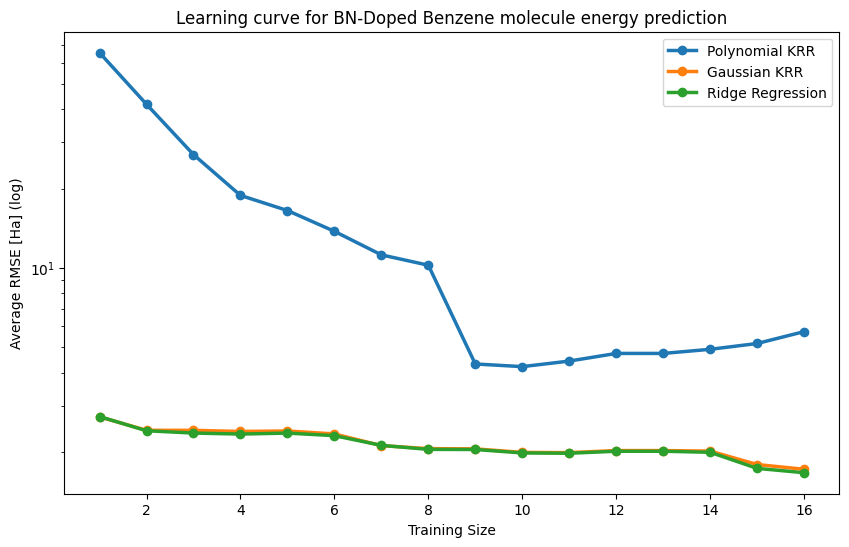

In [85]:
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']
y3 = model_performance_ridge_regression['average RMSE']

# Plotting
plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y3, label='Ridge Regression', marker='o', linestyle='-', linewidth=2.5)


# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
# plt.xscale('log')
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Benz] learning_curve_16_points_no_err_bar.png', dpi=300)
plt.show()


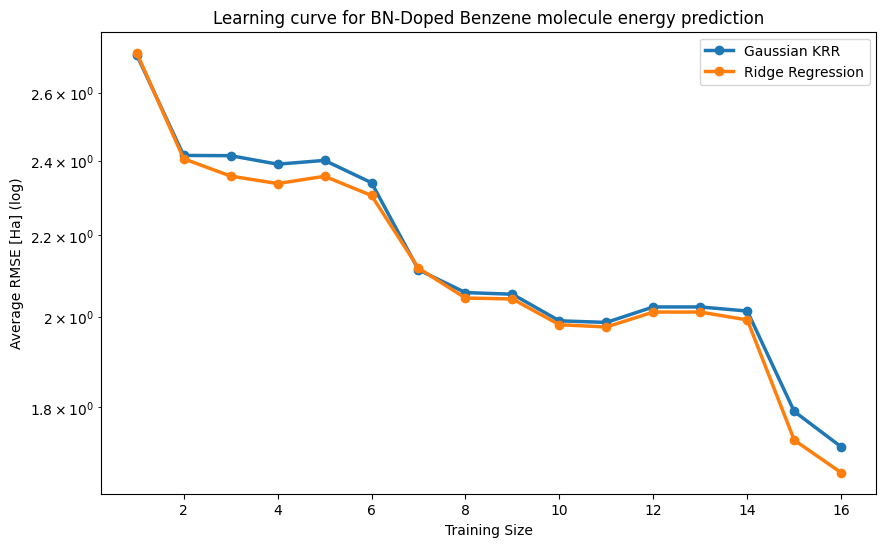

In [87]:
# Plot a version without polynomial KRR, which performed the worst

plt.figure(figsize=(10, 6))

plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y3, label='Ridge Regression', marker='o', linestyle='-', linewidth=2.5)

# Customize the plot
plt.title('Learning curve for BN-Doped Benzene molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
# plt.xscale('log')
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Benz] learning_curve_without_poly_KRR.png', dpi=300)
plt.show()